# Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import joblib
import xgboost
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
import plotly.express as px
import plotly.graph_objects as go
 


## Prep that you already have probably

In [2]:
xgb_tree = joblib.load("xgboost_model.pkl")

c:\Users\Vek00371\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:20:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [3]:
train = pd.read_csv("train.csv")
y_train = train.smoking
X_train = train.drop(columns=["id", "smoking"])

#xgb_tree.fit(X_train,y_train)

# Business case and setting a threshold

After finding the best model we need to set the threshold. The threshold has to be optimalized for the business. In order to do that we made an example use case, but the variables has to be adapted depending on other factors as well, we used average values, so this might be a average threshold over the different customer segments.

As many of the tarifs are signed on a yearly basis this is also how we designed this function.

## Business case

```Disclaimer```\
As the model is trained on the whole train set and we cannot know the true value of the test set, this business case will be done on the train set. This is of course not optimal as we will have to predict the target value back again on the training set in order to complete the business case.\
We chose to do it like this because the other alternative was to do a train test split on the train dataset, but we wanted to train the  model on the whole train set. 

Assumptions: 

- If we classify a non-smoker as a smoker the premium will be felt unfairly high for the customer and the customer will not take the insurance. 
    - We will lose the profit for a non-smoker.

- If we correctly classify a smoker the customer we get the correct market price of a smoker, and will take the insurance.
    - We will get the profit for a smoker.

- If we wrongly classify a smoker as non-smoker the customer will take the insurance, but will pay the price of a non-smoker.
    - The net loss will be the cost of a smoker (price-profit) minus the market price for a non-smoker (the price the customer will pay.)

- If we correctly classify a non-smoker the customer will get a fair market price and will take the insurance
    - We will get the profit for a non-smoker

As the market price for insurance can be vastly different depending on other factors than smoking we want it to be easy to adapt the model to different segments.\
Therefore we will make a customer profit calculator where the business can plot in the price of a non-smoker, a multiplier for price of smokers and estimated profit of the market price. This is a simplification of the pricing model, but it is a decent starting point.\
This calculator will return the estimated profit of classifying a smoker and a non-smoker correctly and uncorrectly.

In [4]:
def customer_profit_calculator(profit_percentage, market_price_non_smoker, smoker_markup):

    market_price_smoker = market_price_non_smoker * smoker_markup
    
    profit_non_smoker = market_price_non_smoker * profit_percentage
    profit_smoker = market_price_smoker * profit_percentage
    

    non_smoker_as_smoker = -profit_non_smoker  # Non-smoker classified as smoker, we lose the profit of a non-smoker.
    smoker_as_smoker = profit_smoker  # Correctly classified smoker, we gain the profit of a smoker.
    non_smoker_as_non_smoker = profit_non_smoker  # Correctly classified non-smoker, we gain the profit of a non-smoker.
    smoker_as_non_smoker = market_price_non_smoker - (market_price_smoker * (1 - profit_percentage))  # Smoker classified as non-smoker, we get net negative profit because the customer will pay non-smoker price.
    
    return {
        'Non-Smoker classified as Smoker': non_smoker_as_smoker,
        'Smoker classafied as smoker': smoker_as_smoker,
        'Non-Smoker classafied as non-smoker': non_smoker_as_non_smoker,
        'Smoker classafied as Non-Smoker': smoker_as_non_smoker,
    }

profits = customer_profit_calculator(0.15, 300, 1.3)
profits


{'Non-Smoker classified as Smoker': -45.0,
 'Smoker classafied as smoker': 58.5,
 'Non-Smoker classafied as non-smoker': 45.0,
 'Smoker classafied as Non-Smoker': -31.5}

With these values we can now make a function that we can use to calculate how our prediction impacted the net profit for each of the rows in the dataset. Later we will sum up the net value for the whole train set for each threshold to see which threshold will give the best returns.

In [5]:
def net_profit_function(true_value, prediction): 
    if true_value == 0 & prediction == 1: #Non-smoker predicted as smoker 
        return -45
    elif true_value == 1 and prediction == 1: #Smoker predicted as smoker
        return 58.5
    elif true_value == 0 and prediction == 0: #Non-smoker predicted as non-smoker
        return 45
    elif true_value == 1 and prediction== 0: #Smoker predicted as non-smoker
        return -31.5
    else:
        return 0

Now we will use the net profit function on each row to get the net value of that row, then we sum the net value of all the rows together for a given threshold. We will pair that sum with the threshold and do this for all thresholds.

In [6]:
probas = xgb_tree.predict_proba(X_train) 
print(xgb_tree.classes_) 
print(probas) #To confirm that the second column of probas is the one that contain probability of being a smoker.

[0 1]
[[0.3011598  0.6988402 ]
 [0.61660075 0.38339922]
 [0.06546974 0.93453026]
 ...
 [0.9974185  0.0025815 ]
 [0.31025797 0.689742  ]
 [0.9467016  0.0532984 ]]


In [7]:
def profit_threshold_calculator(probas, y_train):
    
    y_proba = probas[:, 1]  # Probability of being in the positive class.
    net_profits = []  # To store the sum of the net profits for all rows for each threshold
    thresholds = np.linspace(0, 1, 100)  # We want to test all thresholds.

    for th in thresholds:
        y_pred_num = y_proba >= th  # If the probability is higher than the threshold, it is 1.
        y_pred_num = [1 if x else 0 for x in y_pred_num]  # Make it a list.
        net_profits.append(sum([net_profit_function(true_value, prediction) for true_value, prediction in zip(y_train, y_pred_num)]))

    result = list(zip(net_profits, thresholds))  # Pair the sum of the net profits with the threshold.
    max_profit, optimal_threshold = max(result)  # Find the maximum profit and the corresponding threshold, and unpack the tuple.
    
    return optimal_threshold, max_profit

optimal_threshold, max_profit = profit_threshold_calculator(probas, y_train)
print(f"The maximum possible profit and optimal threshold is: {max_profit} at a threshold of {optimal_threshold}")

The maximum possible profit and optimal threshold is: 6469600.5 at a threshold of 0.393939393939394


We get back that with a threshold of 0.39 we maximize the profit which is 6 469 600.

By using the customer profit calculator, net profit function and the profit-threshold calculator the business will be able to adapt the model to different segments and extract value from the model. 

## Further investigation

We also want to plot the relationship between net profits and the threshold to see how the profits change depending on the threshold. 

In [8]:
#Similar to the profit threshold calculator, but now we want the net profits and and thresholds.
y_proba = probas[:,1] 
net_profits = [] 
thresholds = np.linspace(0,1,100)
for th in thresholds: 
    y_pred_num = y_proba >= th 
    y_pred_num = [1 if x else 0 for x in y_pred_num] 
    net_profits.append(sum([net_profit_function(true_value, prediction) for true_value,prediction in zip(y_train, y_pred_num)]))
    
    

result = zip(net_profits, thresholds) #We only want the pairs of net profits and thresholds for the plot.

In [9]:
px.line(x=thresholds, y=net_profits, title="Net Profit", labels={"x":"Threshold", "y":"Profit"}, template="none")

From the graph we can again see that the threshold that gives the highest profit is around 0.4. We can also see that a lowering or increasing the threshold aroung 0.4 will not change the profit drastically. Lowering the threshold would mean we would predict more people as a smoker. This will probably increase the amount of false positives and therefore lower precision. Predicting more people as a smoker would also mean that we classify more smokers correctly, which is an increase in recall. The opposite is true for raising the threshold. 

With a threshold of zero it would mean that everyone would get classified as a smoker. That means that the only customers would be smokers paying the fee for smokers. This does decrease the profit quite a bit, but it is still a profitable business. 

With a threshold at 1 nobody is classified as a smoker. That means that both smokers and non-smokers pay the non-smoker fee. Then the net profit would be negative, so again it indicates that the most important thing is to classify a smoker as a smoker.



It seems as when the threshold is between 0.1 and 0.6 The profit stays relatively similar. This could mean that in our predictions the portion of predictions between 10% to 60% of being a smoker is quite low. Maybe most of the predictions are outside this interval. Due to this is would be interesting to plot the distribution of predictions to see if this is correct. 


With these considerations in mind we want to do two more plots. One to see how precision and recall are connected and one to see how the probabilities are distributed. 

First we will plot the distribution of predicted probabilities then a plot of precision and recall.

### Distribution of predicted probabilities

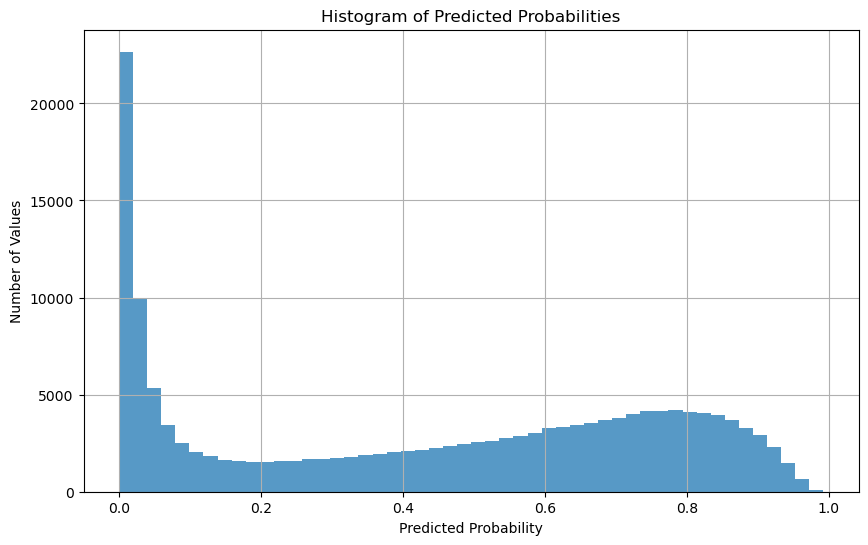

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(y_proba, bins=50, alpha=0.75)

plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Values')

plt.grid(True)
plt.show()

Here we can confirm our beliefs about the distribution of the probabilities. 

The highest consentration of predicted smokers are around 0.8, and it seems on the graph of net profit that the steepest decline on the curve is around the same. That makes sense, because around that threshold we would misclassify a lot a smoker, which would hurt the profits.

When the threshold gets closer to 1 the net profit graph flattes out which, we can see on the probability distribution is because there are few people with predicted probability above 0.9, which would mean that we would not misclassify that many more. 

On the other end of the net profit plot we see a steep decline with a threshold under 0.1 which fits with the probability distribution, because with a threshold under 0.1 we would misclassify a lot of non-smokers. 

Between the edges we see a smooth and steady curve on the profit graph which is due to a relatively similar distribution of probabilities between 0.2 and 0.6. 

### Precision-Recall

The last plot we want to make is a plot of the precision and recall compared to the threshold. This is mainly to confirm our belief that recall is more important than precision.

In [11]:
def plot_prec_rec_th(y_train, y_proba, pos_label=1, neg_label=0):
    thresholds = np.linspace(0,1,100)

    precs = []
    recs = []
    for th in thresholds:
        prediction = y_proba >= th
        prediction = [pos_label if x else neg_label for x in prediction]
        precs.append(precision_score(y_train, prediction, pos_label=pos_label))
        recs.append(recall_score(y_train, prediction, pos_label=pos_label)) 

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=thresholds,
        y=precs,
        name="Precision",
        line_width=3
    ))
    fig.add_trace(go.Scatter(
        x=thresholds,
        y=recs,
        name="Recall",
        line_width=3
    ))

    return fig.update_layout(title=f"Precision-Recall-Threshold Plot", xaxis_title="Threshold", yaxis_title="Precision / Recall", hovermode="x", template="none")

In [12]:
plot_prec_rec_th(y_train, probas[:,1], pos_label=1, neg_label=0)

c:\Users\Vek00371\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



With an optimal threshold of 0,4 we have a recall of 0.92 and a precision of 0.71. This means that it is more important to identify smokers than it is to correctly classify if they are a smoker or not.  That is most likely because that with this configuration and modeling profit as a percentage and not a fixed number, makes smoker predicted as smoker the most valuable customer, and wrongly classifying a smoker quite costly. The higher the multiplicator for smokers is, the more important is recall.  